<center><h1> 视频播放量预测：多种特征的综合分析</h1></center>

# **1 案例目标**

如何利用视频的封面与标题建立模型预测视频播放量。我们希望训练一个模型，使得当我们输入视频的封面和标题后，模型能输出预测的视频播放量

#  **2 基本思路**

我们的思路是：

- （1）将视频封面图片经过迁移学习，变成一个图像特征X向量；

具体而言将封面图片输入模型后，经过卷积神经网络（砍掉全连接层后的）进行图片特征的提取，得到图像特征X

- （2）将标题文本通过编码处理，变成一个文本特征X向量；

使用Tokenizer对标题文本进行编码处理，得到文本特征X

- （3）将播放量作为Y向量，基于X，Y，建立一个LSTM回归模型。


# 3 案例背景

哔哩哔哩（简称B站），从最初围绕ACG文化的视频网站到现在开辟了20多个视频分区的文化娱乐社区，它不断成长演变并吸引了无数年轻人聚集于此，目前平均月度活跃用户已超过2亿。
对于B站上的视频创作者（UP主）而言，高播放量的视频除了能收获众多粉丝外，还能够吸引广告商与之合作从而变现。因此，提高视频的播放量至关重要。严格来说，视频的播放量受诸多因素的影响：从稿件自身来看，有封面与标题的吸引度、内容质量等因素；从传播角度，有观众分享次数、用户是否关注该UP主甚至B站自身推荐系统等因素。

<div>
<img src = "https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fi0.hdslb.com%2Fbfs%2Farticle%2F644819b882a576bb4cb91866d870a71f269719f8.png&refer=http%3A%2F%2Fi0.hdslb.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1648194290&t=5dcfe9acad3ac020b16bc90cdc63f1dd">
</div>

在所有影响因素中，封面与标题是影响播放量的最重要因素之一。一方面，用户进入B站后映入眼帘的首先是视频与封面，而一个视频的标题和封面往往直接影响用户是否点击此视频；另一方面，其他因素如用户分享次数和推荐系统是否推荐与视频发布后第一批观众是否点击播放有关，而第一批观众是否点击播放同样与封面和标题是否吸引人有很大关系。因此，本案例选择分别根据视频的封面与标题对播放量进行预测。




# 4 数据展示

In [3]:
import os
print(os.listdir('data'))                          #展示数据目录结构
img_list=os.listdir('data/Images/')                #所有分析用图片文件名
N=len(img_list); print(N)                          #图片总数

['Images', 'master.csv', '.ipynb_checkpoints']
74185


In [4]:
import pandas as pd
master = pd.read_csv('data/master.csv')             # 读取master信息文件
master                                              # 展示部分数据

,aid,title,follower,view
0,208204291,富奶奶vs穷奶奶/奶奶大战!,25907,5864
1,208212579,兄弟才是隐藏的boss啊,22,125
2,208215972,你到底说还是不说…,19,2
3,208219537,中国朋友教了我一句话：无事献殷勤，非奸即盗。,47,3
4,208237322,如果你是大学里唯一的美人鱼！潜伏技巧！,25907,6357
...,...,...,...,...
74180,890997016,吃我邪神酱飞T,2,1
74181,890997066,《和暗恋女神的厕所之情》,0,78
74182,890997085,串哥和秀文一起连麦选妃,116,275
74183,890997096,我又双叒叕来了,0,3


视频信息文件中各变量含义：

* aid: 视频（图片）编号
* title: 视频标题
* follower: 发布者粉丝数
* view: 视频播放量

### 绘制播放量直方图

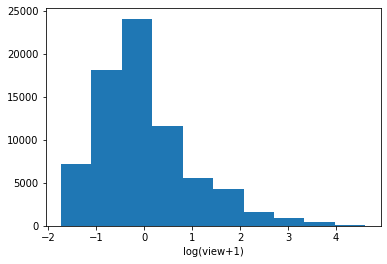

In [3]:
import matplotlib.pyplot as plt
import numpy as np

master['log_view'] = master['view'].apply(lambda x:np.log(x+1))          # 对播放量取对数，记为‘log_view’
master['log_view'] = master['log_view']-np.mean(master['log_view'])      # 对播放量中心化
master['log_view'] = master['log_view']/np.std(master['log_view'])       # 对播放量标准化

plt.hist(master['log_view'])                                             # 对数标准化后播放量直方图
plt.xlabel("log(view+1)")                                                # 添加x轴标签
plt.show()                                                               # 显示图像

# 5 图像数据准备

接下来，我们通过**迁移学习**提取图片特征。具体而言，通过迁移MobileNet模型并截断最后一层输出层，将每一个图片转换转换成1024维的特征X。

In [4]:
from PIL import Image

dx=128;dy=128                                             #确定图片尺寸
N = master.shape[0]                                       #全样本量
n = 3*10**3                                               #教学需要，确定一个不要太大的样本量
img_list=[]                                               #初始化一个list用于存储图像数据
cap_list=[]                                               #初始化一个list用于存储图像的文字标注
follower_list=[]                                          #初始化一个list用于存储粉丝数目
view_list=[]                                              #初始化一个list用于存储播放量（对数标准化后）
for i in range(n):
    pos=np.random.randint(0,N)                            #随机抽取一个图片
    cap_list.append(master.title[pos])                    #记录图片描述用文字
    follower_list.append(np.log(1+master.follower[pos]))  #记录相关粉丝人数
    view_list.append(master.log_view[pos])                #记录播放量
    pic=master.aid[pos]                                   #被选中的图片的ID
    Img=Image.open('data/Images/'+str(pic)+'.jpg')        #读入图像数据
    img_list.append(np.array(Img.resize([dx,dy]))/255)    #记录选中的图片

imgs=np.array(img_list)                                   #形成数组
followers=np.array(follower_list).reshape([n,1])          #形成数组  
views=np.array(view_list).reshape([n,1])                  #形成数组

In [5]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,BatchNormalization

base_model = MobileNet( weights='imagenet',                                       # 加载经过训练的MobileNet模型的权重
                        include_top=False,                                        # 不包含顶端
                        input_shape=(dx, dy, 3))                                  # 输入图片的大小为 128*128*3
x = base_model.output                                                             # 由迁移的MobileNet模型提取图片特征
predict = GlobalAveragePooling2D()(x)                                             # 添加全局平均池化层
model = Model(inputs=base_model.input, outputs=predict)                           # 构建需要训练的完整模型
for layer in base_model.layers: layer.trainable = False                           # 锁住MobileNet的所有层（不进行训练）
imgs=np.array(model(imgs))                                                        # 形成相关的X特征矩阵

2024-04-16 08:04:43.224231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 08:04:44.103943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14264 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:04:00.0, compute capability: 8.6
2024-04-16 08:04:46.727580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2024-04-16 08:04:49.045103: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# 6 文本数据准备

由于文字是非结构化数据，不能在计算机中直接分析，因此对文字进行编码处理。
具体而言，使用Tokenizer建立分词器，根据词频，将每个文本转化为一个整数序列（每个整数都是词典中标记的索引），得到文本数组X

In [6]:
import jieba                                 # 导入jieba包
caps = []                                    # 新建一个空的列表，用于储存训练数据
long_list=[]                                 # 创建一个特别长的list用于存储所有的分词结果
for line in cap_list:                        # 遍历每一个标题
    line_fenci = jieba.lcut(line)            # 对标题进行分词
    caps.append(line_fenci)                  # 将分词后的结果添加到列表中
    long_list=long_list+line_fenci           # 创建一个特别长的list 

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.843 seconds.
Prefix dict has been built successfully.


计算各个关键词的频数

In [7]:
from collections import Counter
skip_list=[',','!','：','《','》','!','?','(',')','，','【','】','（','）','！','？','，','。','#',' ','.']
long_list=[each for each in long_list if each not in skip_list]
long_list=[each for each in long_list if len(each)>1]
tab=Counter(long_list)
keys=[each[0] for each in tab.items() if int(each[1])>5]

重新整理标题描述文本的列表

In [8]:
cap_list_new=[]
for each in caps: cap_list_new.append([kw for kw in each if kw in keys])

对新的文字关键词形成编码

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()                                            #产生一个分词器对象
tokenizer.fit_on_texts(cap_list_new)                               #用标题的文本训练分词器
cap_digit = tokenizer.texts_to_sequences(cap_list_new)             #将每个视频标题的文本转化为序列（列表类型）。每个字通过一个数值表示，每个视频标题的文本即变为这样数值的序列
vocab_size = len(tokenizer.word_index) + 1                         #tokenizer.word_index为所有的词，len(tokenizer.word_index)为词的总个数。加上停止词0
vocab_size                                                         #有多少个不同的词
caps = pad_sequences(cap_digit, maxlen=6,padding='post')          #为了将所有的标题放在一个尺寸M*N的np.array中，将每一个视频的标题补0到同样的长度


# 7 建立一个综合的LSTM模型

### 模型1：全模型（图像+文本+粉丝数）

对于模型1，我们的X为：图像特征，文本特征，以及粉丝数，Y为播放量。

因此我们建立一个回归模型，建立模型后，进行模型编译和训练，这里我们选择的损失函数是'mse'，优化器是'adam'（学习率为0.001）。

In [10]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Activation, Reshape,add
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

dim_img=imgs.shape[1]                                                 #维度：图像数组
dim_follower=1                                                        #维度：粉丝数目
dim_cap=caps.shape[1]                                                 #维度：文字描述
hidden_size = 128                                                     #指定模型中状态空间的维度

inp_img = Input(shape=(dim_img,))                                     #输入层：图像特征向量
inp_follower=Input(shape=(1,))                                        #输入层：粉丝数目
inp_cap=Input(shape=(dim_cap,))                                       #输入层：描述文本
x_img=Dense(hidden_size)(inp_img)                                     #模型处理：图像输入
x_follower=Dense(hidden_size)(inp_follower)                           #模型处理：粉丝数目
x = Embedding(vocab_size, hidden_size)(inp_cap)                       #模型处理：文本向量化
x_cap = LSTM(hidden_size, return_sequences=False)(x)                  #加入一个LSTM网络
x=add([x_img,x_cap,x_follower])                                       #整合不同的输入型号
x=Dense(1)(x)                                                         #输出：预测最后的展现量
model = Model([inp_img,inp_follower,inp_cap], x)                      #模型整合
model.summary()                                                       #打印网络模型摘要表

model.compile(loss='mse', optimizer='adam',metrics=['mse'])           #设计优化方案
model.fit([imgs,followers,caps], views, epochs=100, batch_size=1000)  #小批次样本量

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6, 128)       39680       input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

2024-04-16 08:04:51.920983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 2s 10ms/step - loss: 21.1160 - mse: 21.1160
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 18.4458 - mse: 18.4458
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 7.3296 - mse: 7.3296
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 9.0959 - mse: 9.0959
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 6.4683 - mse: 6.4683
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 4.2797 - mse: 4.2797
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 5.0110 - mse: 5.0110
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 2.5723 - mse: 2.5723
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 3.5940 - mse: 3.5940
Epoch 10/100
3/3 [==============================] - 0s 7ms/step - loss: 2.1870 - mse: 2.1870
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 2.4873 - mse

### 模型2：对比模型（文本+粉丝数）

对于模型2，我们的X为：文本特征和粉丝数，Y为播放量。

因此我们建立一个回归模型，建立模型后，进行模型编译和训练，这里我们选择的损失函数是'mse'，优化器是'adam'（学习率为0.001）。

In [11]:
hidden_size = 128                                                     #指定模型中状态空间的维度
inp_img = Input(shape=(dim_img,))                                     #输入层：图像特征向量
inp_follower=Input(shape=(1,))                                        #输入层：粉丝数目
inp_cap=Input(shape=(dim_cap,))                                       #输入层：描述文本
x_img=Dense(hidden_size)(inp_img)                                     #模型处理：图像输入
x_follower=Dense(hidden_size)(inp_follower)                           #模型处理：粉丝数目
x = Embedding(vocab_size, hidden_size)(inp_cap)                       #模型处理：文本向量化
x_cap = LSTM(hidden_size, return_sequences=False)(x)                  #加入一个LSTM网络
x=add([x_cap,x_follower])                                             #整合不同的输入型号
x=Dense(1)(x)                                                         #输出：预测最后的展现量
model = Model([inp_follower,inp_cap], x)                              #模型整合
model.summary()                                                       #打印网络模型摘要表

model.compile(loss='mse', optimizer='adam',metrics=['mse'])           #设计优化方案
model.fit([followers,caps], views, epochs=100, batch_size=1000)       #小批次样本量

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 128)       39680       input_7[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          131584      embedding_1[0][0]                
____________________________________________________________________________________________


### 模型3：对比模型（图像+文本）

对于模型3，我们的X为：图像特征和文本特征，Y为播放量。

因此我们建立一个回归模型，建立模型后，进行模型编译和训练，这里我们选择的损失函数是'mse'，优化器是'adam'（学习率为0.001）。

In [12]:
hidden_size = 128                                                     #指定模型中状态空间的维度
inp_img = Input(shape=(dim_img,))                                     #输入层：图像特征向量
inp_follower=Input(shape=(1,))                                        #输入层：粉丝数目
inp_cap=Input(shape=(dim_cap,))                                       #输入层：描述文本
x_img=Dense(hidden_size)(inp_img)                                     #模型处理：图像输入
x_follower=Dense(hidden_size)(inp_follower)                           #模型处理：粉丝数目
x = Embedding(vocab_size, hidden_size)(inp_cap)                       #模型处理：文本向量化
x_cap = LSTM(hidden_size, return_sequences=False)(x)                  #加入一个LSTM网络
x=add([x_img,x_cap])                                                  #整合不同的输入型号
x=Dense(1)(x)                                                         #输出：预测最后的展现量
model = Model([inp_img,inp_cap], x)                                   #模型整合
model.summary()                                                       #打印网络模型摘要表

model.compile(loss='mse', optimizer='adam',metrics=['mse'])           #设计优化方案
model.fit([imgs,caps], views, epochs=100, batch_size=1000)            #小批次样本量

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 6, 128)       39680       input_10[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          131200      input_8[0][0]                    
____________________________________________________________________________________________

### 模型4：对比模型（图像+粉丝数）

对于模型4，我们的X为：图像特征和粉丝数，Y为播放量。

因此我们建立一个回归模型，建立模型后，进行模型编译和训练，这里我们选择的损失函数是'mse'，优化器是'adam'（学习率为0.001）。

In [13]:
hidden_size = 128                                                     #指定模型中状态空间的维度
inp_img = Input(shape=(dim_img,))                                     #输入层：图像特征向量
inp_follower=Input(shape=(1,))                                        #输入层：粉丝数目
inp_cap=Input(shape=(dim_cap,))                                       #输入层：描述文本
x_img=Dense(hidden_size)(inp_img)                                     #模型处理：图像输入
x_follower=Dense(hidden_size)(inp_follower)                           #模型处理：粉丝数目
x = Embedding(vocab_size, hidden_size)(inp_cap)                       #模型处理：文本向量化
x_cap = LSTM(hidden_size, return_sequences=False)(x)                  #加入一个LSTM网络
x=add([x_img,x_follower])                                             #整合不同的输入型号
x=Dense(1)(x)                                                         #输出：预测最后的展现量
model = Model([inp_img,inp_follower], x)                              #模型整合
model.summary()                                                       #打印网络模型摘要表

model.compile(loss='mse', optimizer='adam',metrics=['mse'])           #设计优化方案
model.fit([imgs,followers], views, epochs=100, batch_size=1000)       #小批次样本量

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          131200      input_11[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          256         input_12[0][0]                   
____________________________________________________________________________________________

# 思考：如何做得更好？